In [14]:
import numpy as np
from numpy.linalg import solve

def bar(E,A,L,phi):

    '''
    Compute the stiffness and stress matrix for one element

    Parameters
    ----------
    E : float
        modulus of elasticity
    A : float
        cross-sectional area
    L : float
        length of element
    phi : float
        orientation of element

    Outputs
    -------
    K : 4 x 4 ndarray
        stiffness matrix
    S : 1 x 4 ndarray
        stress matrix

    '''
    # rename
    c = np.cos(phi)
    s = np.sin(phi)

    # stiffness matrix
    k0 = np.array([[c**2,c*s],[c*s,s**2]])
    k0_ = np.hstack([k0,-k0])

    K = E*A/L*np.vstack([k0_,-k0_])

    # stress matrix
    S = E/L*np.array([-c,-s,c,s])

    return K,S

def node2idx(node,DOF):

    '''
    Computes the appropriate indices in the global matrix for
    the corresponding node numbers.  You pass in the number of the node
    (either as a scalar or an array of locations), and the degrees of
    freedom per node and it returns the corresponding indices in
    the global matrices
    '''

    idx = np.array([])

    for i in range(len(node)):

        start = DOF*(node[i]-1) + 1
        finish = DOF*node[i]
        stof = np.arange(start,finish+1)

        idx = np.append(idx,stof)

    # reduce indices by 1 to match pythons order
    idx = idx - 1

    # convert to int
    idx = idx.astype(int)

    return idx

def truss(A):

    '''
    Compute mass and stress for the 10-bar truss structure

    Parameters
    ----------
    A : array of length 10 (row or column)
    cross-sectional areas of each bar.
    See image in book for number order if needed.

    Outputs
    -------
    mass : float
        mass of the entire structure
    stress : array of length 10
        corresponding stress of each bar

    '''

    P = 10e3# applied loads in N
    Ls = 9144 # length of sides in mm
    Ld = np.sqrt(2*Ls**2) # length of diagonals

    start = np.array([5, 3, 6, 4, 4, 2, 5, 6, 3, 4])
    finish = np.array([3, 1, 4, 2, 3, 1, 4, 3, 2, 1])
    phi = np.array([0, 0, 0, 0, 90, 90, -45, 45, -45, 45])*np.pi/180
    L = np.array([Ls, Ls, Ls, Ls, Ls, Ls, Ld, Ld, Ld, Ld])

    nbar = len(A)
    E = 69e3*np.ones((nbar,))#68947*np.ones((nbar,)) # modulus of elasticity MPa
    rho = 2.7e-6*np.ones((nbar,)) # material density Kg/mm^3

    Fx = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    Fy = np.array([0.0, -P, 0.0, -P, 0.0, 0.0])
    rigidx = np.array([0, 0, 0, 0, 1, 1])
    rigidy = np.array([0, 0, 0, 0, 1, 1])

    n = len(Fx) # number of nodes
    DOF = 2 # number of degrees of freedom
    nbar = len(A) # number of bars

    # compute mass
    mass = np.sum(rho*A*L)

    # assemble global matrices
    K = np.zeros((DOF*n,DOF*n))
    S = np.zeros((nbar,DOF*n))

    for i in range(nbar):

        # compute submatrices for the element
        Ksub,Ssub = bar(E[i],A[i],L[i],phi[i])

        # inset submatrix into global matrix
        idx = node2idx([start[i],finish[i]],DOF)
        n_idx = len(idx)

        Kind = []
        for ind in range(n_idx):
            Kind.append(idx)

        idx_ = np.vstack(Kind)
        K[idx_,idx_.T] = K[idx_,idx_.T] + Ksub
        S[i,idx] = Ssub

    # setup applied loads
    F = np.zeros((n*DOF,))

    for i in range(n):
        idx = node2idx([i+1],DOF)
        F[idx[0]] = Fx[i]
        F[idx[1]] = Fy[i]
    node_ = np.arange(1,7)
    idxx = (rigidx != 0);idxx = node_[idxx]
    idxy = (rigidy != 0);idxy = node_[idxy]
    removex = node2idx(idxx,DOF)
    removey = node2idx(idxy,DOF)

    nx = len(removex)
    ind_nx = np.arange(0,nx,2)
    removex = removex[ind_nx]

    ny = len(removey)
    ind_ny = np.arange(1,ny,2)
    removey = removey[ind_ny]

    remove = np.hstack([removex,removey])

    K = np.delete(K,remove,axis = 0)
    K = np.delete(K,remove,axis = 1)
    F = np.delete(F,remove)
    S = np.delete(S,remove,axis = 1)

    # solve for deflections
    d = solve(K,F)

    # compute stress
    stress = S.dot(d)

    return mass,stress




`gtol` termination condition is satisfied.
Number of iterations: 118, function evaluations: 1243, CG iterations: 182, optimality: 2.17e-09, constraint violation: 0.00e+00, execution time:  0.6 s.
mass (Kg)= 26.429670534765016

X = [193.55327874   1.00009081 194.79642157  96.46588536   1.00019112
   1.00027244 138.18131666 136.42341473 136.42350244   1.00035734]
stress = [ 1.02999989e+02  6.40083745e+01 -1.02999912e+02 -1.02999996e+02
 -1.34835766e-04  6.39967517e+01  1.02999927e+02 -1.02999956e+02
  1.02999891e+02 -9.04973934e+01]


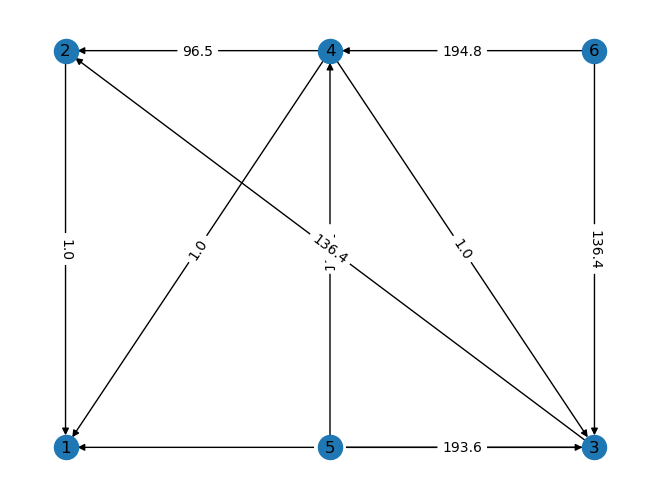

In [ ]:
import numpy as np
#from truss import truss
from scipy.optimize import (BFGS, SR1, Bounds, NonlinearConstraint, minimize)
import matplotlib.pyplot as plt
import networkx as nx



# Solving a Three Variable Multivariable Constrained Optimization

Find the dimensions of the box with largest volume if the total surface area is $64 cm^2$

$Volume = f(x_0,x_1,x_2) = x_0 x_1x_2$

$Surface Area = g(x_0,x_1,x_2) = 2x_0x_1 + 2x_1x_1 + 2x_0x_2 = 64$

In [57]:
import numpy as np
from scipy.optimize import minimize

def objective(x):
    """Volume of the box (to be maximized)"""
    return -x[0] * x[1] * x[2]  # Negative for maximization

def constraint(x):
    """Surface area constraint: 2(xy + xz + yz) = 64"""
    return 2*(x[0]*x[1] + x[0]*x[2] + x[1]*x[2]) - 64

def grad_objective(x):
    """Gradient of the volume function"""
    return -np.array([x[1]*x[2], x[0]*x[2], x[0]*x[1]])

def grad_constraint(x):
    """Gradient of the surface area constraint"""
    return 2*np.array([x[1] + x[2], x[0] + x[2], x[0] + x[1]])

def augmented_lagrangian(x, λ, μ):
    """Augmented Lagrangian function"""
    return objective(x) + λ*constraint(x) + (μ/2)*constraint(x)**2

def grad_augmented_lagrangian(x, λ, μ):
    """Gradient of the augmented Lagrangian"""
    return grad_objective(x) + λ*grad_constraint(x) + μ*constraint(x)*grad_constraint(x)

def solve_with_augmented_lagrangian():
    # Initial guesses
    x0 = np.array([2.0, 2.0, 2.0])  # Initial dimensions
    λ = 0.0  # Initial Lagrange multiplier
    μ = 1.0  # Initial penalty parameter
    μ_max = 1e6  # Maximum penalty parameter
    tol = 1e-6  # Tolerance
    max_iter = 100  # Maximum outer iterations

    for k in range(max_iter):
        # Solve the unconstrained subproblem
        res = minimize(lambda x: augmented_lagrangian(x, λ, μ),
                       x0,
                       jac=lambda x: grad_augmented_lagrangian(x, λ, μ),
                       method='BFGS')

        x_opt = res.x
        constraint_val = constraint(x_opt)

        # Update Lagrange multiplier
        λ += μ * constraint_val

        # Check convergence
        if abs(constraint_val) < tol:
            break

        # Increase penalty parameter if needed
        if abs(constraint_val) > 0.25 * abs(constraint(x0)):
            μ = min(2*μ, μ_max)

        x0 = x_opt

    return x_opt, λ, k+1

# Solve the problem
optimal_dims, lambda_opt, iterations = solve_with_augmented_lagrangian()
volume = -objective(optimal_dims)
surface_area = constraint(optimal_dims) + 64

print(f"Optimal dimensions (x, y, z): {optimal_dims}")
print(f"Volume: {volume:.4f} cm³")
print(f"Surface area: {surface_area:.4f} cm² (constraint: 64 cm²)")
print(f"Number of outer iterations: {iterations}")
print(f"Optimal Lagrange multiplier: {lambda_opt:.4f}")

# For a cube (which we know is optimal for this problem)
cube_side = np.sqrt(64/6)
print(f"\nTheoretical cube solution (for verification):")
print(f"Side length: {cube_side:.4f} cm")
print(f"Volume: {cube_side**3:.4f} cm³")

Optimal dimensions (x, y, z): [3.26598632 3.26598632 3.26598632]
Volume: 34.8372 cm³
Surface area: 64.0000 cm² (constraint: 64 cm²)
Number of outer iterations: 4
Optimal Lagrange multiplier: 0.8165

Theoretical cube solution (for verification):
Side length: 3.2660 cm
Volume: 34.8372 cm³


with JAX

In [59]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg

from numpy import nanargmin,nanargmax

key = random.PRNGKey(42)

In [60]:
def f(x): return x[0]*x[1]*x[2]
def g(x): return 2*x[0]*x[1] + 2*x[1]*x[2] + 2*x[0]*x[2] - 64

minfunc = vmap(f)

def Lagrange(l): return f(l[0:3]) - l[3]*g(l[0:3])

L = jacfwd(Lagrange)
gradL = jacfwd(L)

In [61]:
def solveLagrangian(l): return l - 0.1*linalg.inv(gradL(l)) @ L(l)

domain = random.uniform(key, shape=(50,4), dtype='float32',
                        minval=0, maxval=10)

vfuncsLAG = vmap(solveLagrangian)
for epoch in range(200):
  domain = vfuncsLAG(domain)


maximums = minfunc(domain)

In [62]:
arglist = nanargmax(maximums)
argmin = domain[arglist]
minimum = maximums[arglist]

print("The minimum is {}, the argmin is ({},{},{}), the lagrangian is {}".format(minimum,argmin[0],
                                                                                         argmin[1],
                                                                                         argmin[2],
                                                                                         argmin[3]))

The minimum is 34.83722686767578, the argmin is (3.2659881114959717,3.2659873962402344,3.2659873962402344), the lagrangian is 0.8164968490600586
